In [1]:
# PROTOTYPE Code for energy reconstruction using the Symmetric LDF
# Ready to read simulations from CORSIKA/Coreas
# using the grand official package
# Date: April 08, 2020

# Written by Bruno L. Lago

In [2]:
from modERec import EnergyRec
import numpy as np
import matplotlib.pyplot as plt

* EnergyRec default values summary:
--> bool_plot =  False
--> bool_EarlyLate =  True
--> nu_low =  50
--> nu_high =  200
--> SNR_thres =  10
--> thres_low =  1e-07
--> thres_high =  1
--> f_thres =  0.01
--> printLevel =  0




# Training stage of $a_{ratio}$

The following blocks are used to train the method and determine the parameters of $a_{ratio}$.

$$a(r,d_{max},\rho_{max};{\boldsymbol p}) = p_0.\frac{r}{d_{max}}.\exp \left(\frac{r}{p_1}\right).
\left[ \exp\left(\frac{\rho_{max}-<\rho_{max}>}{p_2}\right)-p_3\right]$$

The first step is to evaluate several quantities of interest: geomagnetic fluence, charge excess fluence, geomagnetic angle, axis distance of the antennas, distance to the $X_{max}$ and density at the $X_{max}$.

In [3]:
def quantities(sim_dir):
    rec1 = EnergyRec(sim_dir)

    weight = np.array([ant.wEarlyLate for ant in rec1.antenna])
    r_proj = np.array([ant.r_proj for ant in rec1.antenna])
    fluence_geo = np.array([ant.fluence_geo for ant in rec1.antenna])/(weight**2)
    fluence_ce = np.array([ant.fluence_ce for ant in rec1.antenna])/(weight**2)

#     print(rec1.shower.r_proj,"\n")
#     print(rec1.shower.r_Core_proj,"\n")
#     print(weight)
    n_ant = len(rec1.GRANDshower.fields)
    alpha = np.full(n_ant,np.arccos(np.dot(rec1.shower.ev,rec1.shower.eB)))
    distance = np.linalg.norm((r_proj - rec1.shower.r_Core_proj)[:,0:2],axis=1)*weight
    d_Xmax = np.full(n_ant,rec1.shower.d_Xmax)
    rho_Xmax = np.full(n_ant,rec1.SymFit.rho(d_Xmax[0],-rec1.shower.ev))
    
    return fluence_geo, fluence_ce, alpha, distance, d_Xmax, rho_Xmax

### Loop over the simulations

Loop over the simulations and store the corresponding quantities.

In [4]:
fluence_geo = np.array([])
fluence_ce = np.array([])
alpha = np.array([])
distance = np.array([])
d_Xmax = np.array([])
rho_Xmax = np.array([])

for i in range(100001,100021):
    sim_dir = '/mnt/d/Pesquisa/GRAND/simulation/chuv_estrela/80deg/sim' + str(i)

    f_geo, f_ce, a, d, d_max, rho_max = quantities(sim_dir)
    fluence_geo = np.append(fluence_geo,f_geo)
    fluence_ce = np.append(fluence_ce,f_ce)
    alpha = np.append(alpha,a)
    distance = np.append(distance,d)
    d_Xmax = np.append(d_Xmax,d_max)
    rho_Xmax = np.append(rho_Xmax,rho_max)

### Perform the fit

In [5]:
bestfit = EnergyRec.SymFit.a_ratio_fit(fluence_geo, fluence_ce,alpha, distance, d_Xmax, rho_Xmax)
print(EnergyRec.SymFit.a_ratio_chi2(bestfit,fluence_geo, fluence_ce,alpha, distance, d_Xmax, rho_Xmax))
print(bestfit)

0.002064248046781925
[1.97915209e-03 2.19519197e+02 3.64956328e-01 1.16415162e-01]


# Plot of a single simulation

The following blocks plot the early-late corrected $f_{\bf{v}\times\bf{B}}$ and the symmetrized signal distribution
$$f_{par} = \frac{f_{\bf{v}\times\bf{B}}}{\left(1+\frac{\cos(\phi)}{|\sin(\alpha)|}.\sqrt{(a(r,d_{max},\rho_{max})}\right)^2}$$

In [6]:
rec1 = EnergyRec(sim_dir)

fluence_par = rec1.Eval_par_fluences(bestfit)

r_proj = np.array([ant.r_proj for ant in rec1.antenna])

distance = np.linalg.norm((r_proj - rec1.shower.r_Core_proj)[:,0:2],axis=1)
d_Xmax = rec1.shower.d_Xmax
rho_Xmax = rec1.SymFit.rho(d_Xmax,-rec1.shower.ev)

-0.0025726271302768137 0.05991265467697983


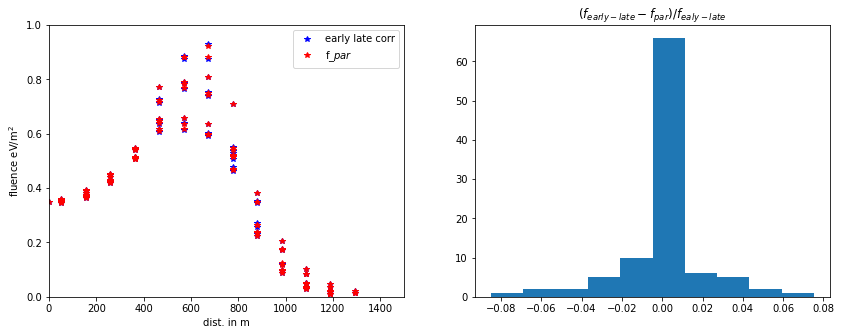

In [7]:
plt.figure(figsize=[14,5])
r_proj = np.array([ant.r_proj for ant in rec1.antenna])
distance = np.linalg.norm((r_proj - rec1.shower.r_Core_proj)[:,0:2],axis=1)

fluence_arr = np.array([ant.fluence for ant in rec1.antenna])
fluence_evB = np.array([ant.fluence_evB/(ant.wEarlyLate**2) for ant in rec1.antenna])

sel = np.where(fluence_arr>0.01)
plt.subplot(121)
#plt.plot(distance,fluence_evB_unc,"g*", label="raw")
plt.plot(distance[sel],fluence_evB[sel],"b*", label = "early late corr")
plt.plot(distance[sel],fluence_par[sel],"r*", label = r'f_${par}$')

plt.ylim(0,1)
plt.xlim(0,1500)

plt.xlabel("dist. in m")
plt.ylabel("fluence eV/m$^2$")

plt.legend()

#plt.gca().set_yscale('log')

plt.subplot(122)

diff = (fluence_evB - fluence_par)/fluence_evB
plt.hist(diff[sel],10)
plt.title("($f_{early-late}-f_{par})/f_{ealy-late}$")

print(np.mean(diff),np.std(diff))

# Plots the $a_{ratio}$

Divided by the exponential term as a function of the off axis angle.

Text(0, 0.5, '$a/\\left[ \\exp\\left(\\frac{\\rho_{max}-<\\rho_{max}>}{p_2}\\right)-p_3\\right]$')

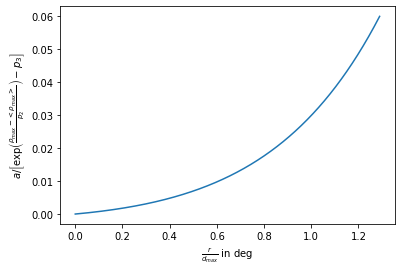

In [8]:
dist = np.array(range(1500))
par = [0.373, 762.6, 0.149, 0.189]
a_ratio = rec1.SymFit.a_ratio(dist, d_Xmax, par, rho_Xmax)
den = np.exp((rho_Xmax-0.4)/0.149)-0.189
plt.plot(dist/d_Xmax*180/np.pi,a_ratio/den)
plt.xlabel(r'$\frac{r}{d_{max}}$ in deg')
plt.ylabel(r'$a/\left[ \exp\left(\frac{\rho_{max}-<\rho_{max}>}{p_2}\right)-p_3\right]$')

### Plots the $f_{par}$

The following block plots the $f_{par}$

Text(0, 0.5, 'fluence eV/m$^2$')

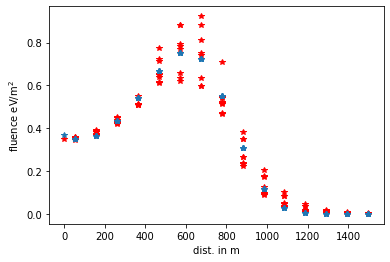

In [9]:
sel = np.where(fluence_par>0)
ldf_par = rec1.SymFit.SymLDF_fit(distance[sel],fluence_par[sel])
f_par = rec1.SymFit.SymLDF(ldf_par,distance)
plt.plot(distance[sel],fluence_par[sel],"r*")
plt.plot(distance[sel],f_par[sel],"*")

plt.xlabel("dist. in m")
plt.ylabel("fluence eV/m$^2$")

# Training stage of the $S_{radio}$

The $f_{par}$ is fitted using 
$$f_{ABCD}(r) = A.\exp\left[-B.r -C.r^2 -D.r^3 \right] $$

The following block evaluates several quantities of interest for each simulation: the parameters of the ldf fit , the geomagnetic angle, the density at the $X_{max}$ and the energy. 

In [10]:
ldf_par_arr = np.empty(shape=(0, 4))
alpha_arr = np.array([])
rho_Xmax_arr = np.array([])
E_arr = np.array([])

for i in range(100001,100021):
    sim_dir = '/mnt/d/Pesquisa/GRAND/simulation/chuv_estrela/80deg/sim' + str(i)
    rec1 = EnergyRec(sim_dir)
 
    r_proj = np.array([ant.r_proj for ant in rec1.antenna])
    distance = np.linalg.norm((r_proj - rec1.shower.r_Core_proj)[:,0:2],axis=1)
    
    fluence_par = rec1.Eval_par_fluences(bestfit)
    sel = np.where(fluence_par>0)
    
    ldf_par = rec1.SymFit.SymLDF_fit(distance[sel],fluence_par[sel])
    d_Xmax = rec1.shower.d_Xmax
    rho_Xmax = rec1.SymFit.rho(d_Xmax,-rec1.shower.ev)

    ldf_par_arr = np.vstack((ldf_par_arr,[ldf_par]))
    alpha_arr = np.append(alpha_arr,[np.arccos(np.dot(rec1.shower.ev,rec1.shower.eB))])
    rho_Xmax_arr = np.append(rho_Xmax_arr,[rho_Xmax])
    E_arr = np.append(E_arr,[rec1.GRANDshower.energy.to("EeV").value])

### The energy estimator

The radiation energy (integral of the symmetric LDF) hsa to be corrected according
$$S_{rad} = \frac{E_{rad}}{\sin^2(\alpha)}.\frac{1}{1-par_0+par_0.\exp\left[par_1.(\rho_{max}-0.648\, {\rm kg/m^3}) \right]}$$

The $S_{radio}$ is related to the energy via
$$S_{rad} = S_{19}.\left( \frac{E}{10 {\rm EeV}}\right)^\gamma$$

The parameters of the above equations are obtained through a joint fit to all simulations.

In [11]:
joint_bestfit = rec1.SymFit.joint_S_fit(ldf_par_arr,alpha_arr,rho_Xmax_arr,E_arr)
print(joint_bestfit)

[ 1.56168476e+01 -6.56273889e+01  3.99405798e-18 -6.30425319e+00]


# $S_{radio}\times$  energy relation

When simulations for different energies are available this block will plot the relation between $S_{radio}$ and the energy.

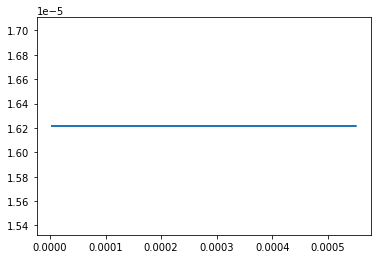

In [12]:
S_geo = np.zeros(len(ldf_par_arr))
S_mod = np.zeros(len(ldf_par_arr))

for i in range(len(ldf_par_arr)):
    S_geo[i] = EnergyRec.SymFit.Sradio_geo(joint_bestfit[0:2],ldf_par_arr[i],alpha_arr[i],rho_Xmax_arr[i])
    S_mod[i] = EnergyRec.SymFit.Sradio_mod(joint_bestfit[2:4],E_arr[i])

plt.plot(S_geo,S_mod)

# $S_{radio}$ distribution

Since it was not possible to fit the parameters of the $S_{radio}\times$ energy relation. The following block plots the $S_{rad}$ obtained using the parameters from the ICRC proceeding 2019 by Tim Huege.

(array([2., 1., 1., 3., 2., 3., 3., 1., 2., 2.]),
 array([0.82423278, 0.8596064 , 0.89498002, 0.93035363, 0.96572725,
        1.00110087, 1.03647448, 1.0718481 , 1.10722172, 1.14259533,
        1.17796895]),
 <a list of 10 Patch objects>)

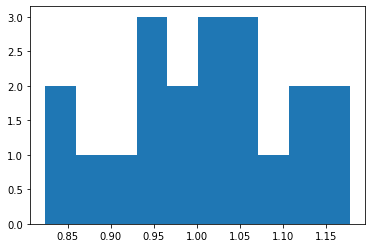

In [13]:
p0 = 0.394
p1 = -2.370 #m^3/kg
S_19 = 1.408 #GeV
gamma = 1.995
par_Tim = [p0,p1,S_19,gamma]

S_geo_Tim = np.zeros(len(ldf_par_arr))

for i in range(len(ldf_par_arr)):
    S_geo_Tim[i] = EnergyRec.SymFit.Sradio_geo(par_Tim[0:2],ldf_par_arr[i],alpha_arr[i],rho_Xmax_arr[i])

#plt.hist(S_geo_Tim)

plt.figure()
plt.hist(np.sqrt(S_geo_Tim*1e-9/S_19)*100/2.8) # forced division by 2.8